In [4]:
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
pip install netCDF4

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Gustavi\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


## TAASRAD19, a high-resolution weather radar reflectivity dataset for precipitation nowcasting

Radar sequences years 2010 - 2019 (NETCDF).

In [6]:
FILE = './training/20101101.nc'
ds = xr.open_mfdataset(FILE)
ds

<xarray.Dataset>
Dimensions:                         (x: 480, y: 480, time: 286)
Coordinates:
  * x                               (x) int32 549850 550350 ... 788850 789350
  * y                               (y) int32 5271250 5270750 ... 5031750
  * time                            (time) datetime64[ns] 2010-11-01 ... 2010...
Data variables:
    transverse_mercator             |S1 ...
    equivalent_reflectivity_factor  (time, y, x) float32 dask.array<chunksize=(286, 480, 480), meta=np.ndarray>
Attributes:
    Conventions:         CF-1.7
    GDAL_AREA_OR_POINT:  Area
    title:               MAX(Z) Reflectivity day 2010-11-01
    institution:         Meteotrentino, Fondazione Bruno Kessler
    source:              radar observation mt.Macaion
    site_lat_lon_elev:   46.494002, 11.208826, 1876
    references:          original dataset https://doi.org/10.5281/zenodo.3577451
    comments:            NetCDF generation code https://github.com/MPBA/TAASR...
    chunks:              164 122
    tags:                rain snow

In [17]:
ds.tags

'rain snow'

In [7]:
reflectivity_ds = ds.equivalent_reflectivity_factor  

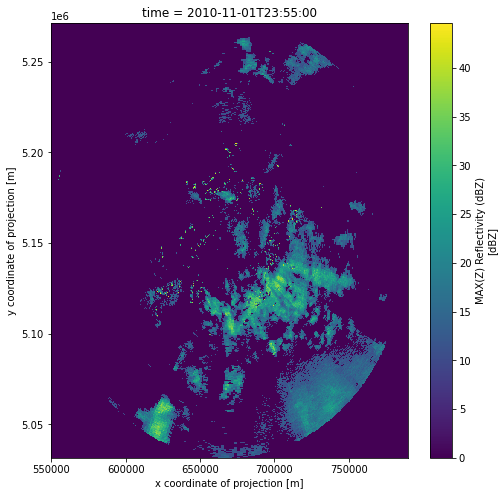

In [8]:
plt.figure(figsize=(8,8));
reflectivity_ds[-1].plot.pcolormesh(x='x', y='y', add_colorbar=True);

## Janelas deslizantes

Dada uma sequencia, o método abaixo cria subsequencias a partir da sequência original.

In [9]:
def window_generator(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        
        end_ix = i + n_steps
        
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return x, y

In [10]:
seq = list(range(1,11))
seq

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [11]:
x, y = window_generator(seq, 3)

In [12]:
x

[[1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8], [7, 8, 9]]

In [13]:
y

[4, 5, 6, 7, 8, 9, 10]

Usando a mesma ideia, mas criando já os datasets no formato Xarray, e também fazendo com que `y` seja uma sequência de mesmo tamanho que `x`.

In [14]:
def window_generator_xarray(dataset, n_steps):
    x, y = list(), list()
    for i in range(len(dataset)):
        end_ix = i + n_steps
        end_iy = end_ix + n_steps

        x_data = dataset.isel(time=slice(i,end_ix))
        x_data = x_data.expand_dims(dim='sample', axis=0)
        y_data = dataset.isel(time=slice(end_ix,end_iy))
        y_data = y_data.expand_dims(dim='sample', axis=0)

        if y_data.time.size < n_steps:
            break
        
        x_data = x_data.drop(labels='time')
        x.append(x_data)
        y_data = y_data.drop(labels='time')
        y.append(y_data)

    return x, y

In [15]:

x_list, y_list = window_generator_xarray(reflectivity_ds, n_steps=5)
x_data = xr.concat(x_list, dim='sample')
x_data = x_data.expand_dims(dim='channel', axis=-1)

y_data = xr.concat(y_list, dim='sample')
y_data = y_data.expand_dims(dim='channel', axis=-1)

print('Sample size with X: ', x_data.sample.size)
print('Sample size with y: ', y_data.sample.size)

Sample size with X:  277
Sample size with y:  277


In [16]:
x_data

,Array,Chunk
Bytes,1.19 GiB,4.39 MiB
Shape,"(277, 5, 480, 480, 1)","(1, 5, 480, 480, 1)"
Count,1387 Tasks,277 Chunks
Type,float32,numpy.ndarray
